# Source Based Fake News Classification

Social media is a vast pool of content, and among all the content available for
users to access, news is an element that is accessed most frequently. This news
can be posted by politicians, news channels, newspaper websites, or even
common civilians. These posts must be checked for their authenticity, since
spreading misinformation has been a real concern in today’s times, and many
firms are taking steps to make the common people aware of the consequences of
spreading misinformation. The measure of authenticity of the news posted online
cannot be definitively measured, since the manual classification of news is
tedious and time-consuming and is also subject to bias.

This notebook will try to predict the classification of news based on the authenticity using the classes: 'Real' and 'Fake'.


## Importing Dependencies

In [ ]:

# Installing libraries for experiment tracking
%pip install mlflow

# Installing libaries for hyperparameter optimization
%pip install hyperopt

# Installing python library for profiling the data
! pip install datasist

# Installing python library for accessing feature importance of model
! pip install shap

     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ----------- ---------------------------- 0.4/1.6 MB 13.9 MB/s eta 0:00:01
     ------------------------ --------------- 1.0/1.6 MB 10.2 MB/s eta 0:00:01
     ----------------------------- ---------- 1.2/1.6 MB 10.7 MB/s eta 0:00:01
     ---------------------------------------  1.6/1.6 MB 9.1 MB/s eta 0:00:01
     ---------------------------------------- 1.6/1.6 MB 8.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/200.5 kB ? eta -:--:--
     -------------------------------------- 200.5/200.5 kB 6.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Importing Libraries

In [6]:
# for data set exploration
import datasist as ds
import missingno as msno
import numpy as np
import pandas as pd

from collections import Counter


# for data visualizations
import matplotlib.pyplot as plt
import seaborn as sns


# Setting visualization styles
%matplotlib inline
sns.set()

# for text processing
import nltk
import re

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize


# for model building training and testing
import time
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
import xgboost as xgb

# For experiment tracking
import mlflow

# For hyperparameter optimization
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

# for model feature importance
import shap

warnings.filterwarnings("ignore")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Importing necessary word dictionaries

In [7]:
# Downloading necessary word dictionaries for text processing
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('brown')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ologa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ologa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ologa\AppData\Roaming\nltk_data...
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\ologa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ologa\AppData\Roaming\nltk_data...


True

## Importing dataset

In [8]:
# Importing the train and test data into a pandas dataframe
raw_data = pd.read_csv(r"Train data.csv")
test_data = pd.read_excel(r"Test data.xlsx")

## Data Profiling

In [9]:
# Using datasist API for data exploration
ds.structdata.describe(raw_data)

First five data points


,author,published,title,text,language,site_url,main_img_url,type,title_without_stopwords,text_without_stopwords,hasImage,label
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0,Real
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0,Real
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \r\nfox news sunday reported this m...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0,Real
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0,Real
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0,Real




Random five data points


,author,published,title,text,language,site_url,main_img_url,type,title_without_stopwords,text_without_stopwords,hasImage,label
1523,No Author,2016-10-26T23:00:11.208+03:00,magnitude earthquake jolts central italy,iraq iraqi forces gather near the village of s...,english,presstv.ir,http://media.presstv.com/photo/20161026/20884c...,state,khartoum protest land grab turns violent,debate natos eastward expansion episode debate...,1.0,Real
1423,Sean Colarossi,2016-10-28T05:12:12.375+03:00,trump is ahead in zero national polls while th...,by rmuse am the archdiocese holds the matte...,english,politicususa.com,http://15130-presscdn-0-89.pagely.netdna-cdn.c...,bias,senator mark kirk mocks disabled veteran tammy...,october surprise aimed opponent flops polls ba...,1.0,Real
1567,No Author,2016-10-27T13:29:05.251+03:00,presstvbrazil football legend carlos alberto l...,pakistan this photo taken in lahore on october...,english,presstv.ir,http://media.presstv.com/photo/20161027/cb1024...,state,italian banks struggling stay afloat,news bulletin iranian youngsters lost saudi ar...,1.0,Real
762,EdJenner,2016-11-10T21:12:48.162+02:00,watch cornell university holding cry ins to mo...,in a campuswide email to students north caroli...,english,dailywire.com,http://conservativeangle.com/wp-content/upload...,bias,watch cornell university holding cry ins mourn...,campuswide email students north carolina nc st...,1.0,Real
274,Activist Post,2016-11-07T03:55:20.620+02:00,election uncertainty now influencing gold and ...,by bernie suarez its always important to keep ...,english,activistpost.com,No Image URL,conspiracy,election uncertainty influencing gold silver p...,bernie suarez always important keep strong per...,0.0,Fake




Last five data points


,author,published,title,text,language,site_url,main_img_url,type,title_without_stopwords,text_without_stopwords,hasImage,label
1595,No Author,2016-10-28T03:13:46.387+03:00,iraqi forces score major gains south of mosul,on today at pm duterte wants foreign troops ...,english,presstv.ir,http://media.presstv.com/photo/20161027/d3bfdb...,state,trump vps plane slides runway new york airport,reply today pm part mother child worship https...,1.0,Real
1596,No Author,2016-10-28T03:13:47.181+03:00,us supreme court justice groped female lawyer ...,reply on july pm russia eu prolongs econo...,english,presstv.ir,http://media.presstv.com/photo/20161028/54a83d...,state,presstvrussia cancels request fuel ships spain,today pm solar winds spur geomagnetic storm ma...,1.0,Real
1597,No Author,2016-10-28T03:45:23.031+03:00,trump vps plane slides off runway at new york ...,reply on today at pm part mother child wo...,english,presstv.ir,http://media.presstv.com/photo/20161026/ef2031...,state,study swift birds fly nonstop months every year,today pm aig quadruples limits terrorism insur...,1.0,Real
1598,No Author,2016-10-26T08:00:00.000+03:00,presstvrussia cancels request to fuel ships in...,on today at pm solar winds spur geomagnetic ...,english,presstv.ir,http://media.presstv.com/photo/20161028/b440d4...,state,yemeni forces fire ballistic missile saudi ara...,windows reply november pm nvidia even admitted...,1.0,Real
1599,No Author,2016-10-28T04:21:55.986+03:00,study swift birds fly nonstop for months ever...,on today at pm aig quadruples limits for ter...,english,presstv.ir,http://media.presstv.com/photo/20161028/f25eb3...,state,fastest electric commuter ferry unveiled sweden,logged answer one people fictional entity crea...,1.0,Real




Shape of  data set: (1600, 12)


Size of  data set: 19200


Data Types
Note: All Non-numerical features are identified as objects in pandas


,Data Type
author,object
published,object
title,object
text,object
language,object
site_url,object
main_img_url,object
type,object
title_without_stopwords,object
text_without_stopwords,object




Column(s) {'published'} should be in Datetime format. Use the [to_date] function in datasist.feature_engineering to convert to Pandas Datetime format


Numerical Features in Data set
['hasImage']


Categorical Features in Data set


['author',
 'published',
 'title',
 'text',
 'language',
 'site_url',
 'main_img_url',
 'type',
 'title_without_stopwords',
 'text_without_stopwords',
 'label']



Statistical Description of Columns


,hasImage
count,1598.000000
mean,0.831665
std,0.374281
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000




Description of Categorical Features


,count,unique,top,freq
author,1599,300,No Author,443
published,1600,1514,2016-10-30T13:00:00.000+02:00,8
title,1600,1461,no title,79
text,1600,1516,notify me of followup comments by email notify...,6
language,1599,5,english,1522
site_url,1599,45,infowars.com,100
main_img_url,1599,1065,No Image URL,269
type,1599,9,bs,524
title_without_stopwords,1597,1458,title,79
text_without_stopwords,1598,1514,notify followup comments email notify new post...,6




Unique class Count of Categorical features


,Feature,Unique Count
0,author,301
1,published,1514
2,title,1461
3,text,1516
4,language,6
5,site_url,46
6,main_img_url,1066
7,type,10
8,title_without_stopwords,1459
9,text_without_stopwords,1515




Missing Values in Data


,features,missing_counts,missing_percent
0,author,1,0.1
1,published,0,0.0
2,title,0,0.0
3,text,0,0.0
4,language,1,0.1
5,site_url,1,0.1
6,main_img_url,1,0.1
7,type,1,0.1
8,title_without_stopwords,3,0.2
9,text_without_stopwords,2,0.1


The training data contains 12 columns and 1600 rows. The columns data types need to be changed to proper data types. There are also some missing values in a number of columns. The training data needs to be cleaned.

In [10]:
# Using datasist API for data exploration
ds.structdata.describe(test_data)

First five data points


,author,published,title,text,language,site_url,main_img_url,type,title_without_stopwords,text_without_stopwords,hasImage
0,No Author,2016-10-28T04:22:01.276+03:00,yemeni forces fire ballistic missile at saudi ...,re windows reply on november pm nvidia ...,english,presstv.ir,http://media.presstv.com/photo/20161028/e40abc...,state,massive marine park declared antarctic ocean,largest public pensions face trillion hole rep...,1.0
1,No Author,2016-10-28T04:22:07.575+03:00,fastest electric commuter ferry unveiled in sw...,logged the answer to is i am one of the peopl...,english,presstv.ir,http://media.presstv.com/photo/20161028/fb09c4...,state,comprehensive international resolve key terror...,author topic obsolete read times members guest...,1.0
2,No Author,2016-10-28T18:02:37.152+03:00,massive marine park declared in antarctic ocean,re largest public pensions face trillion hole...,english,presstv.ir,http://media.presstv.com/photo/20161028/d8fad9...,state,many instances voter fraud gop vp candidate pence,today pm lines profit misses estimates ads pus...,1.0
3,No Author,2016-10-28T18:02:37.902+03:00,comprehensive international resolve key to ter...,author topic obsolete read times members an...,english,presstv.ir,http://media.presstv.com/photo/20161028/b28af3...,state,five filipino hostages freed somali pirates re...,today pm nintendo cuts fullyear sales operatin...,1.0
4,No Author,2016-10-28T18:02:38.498+03:00,there are many instances of voter fraud gop vp...,on today at pm lines profit misses estimates...,english,presstv.ir,http://media.presstv.com/photo/20161028/449bd2...,state,palestinian homes razed occupied w banks area c,reply april pm fukushima disaster caused least...,1.0




Random five data points


,author,published,title,text,language,site_url,main_img_url,type,title_without_stopwords,text_without_stopwords,hasImage
454,-NO AUTHOR-,2016-10-27T03:32:37.291+03:00,fascinated with sex,NaN,english,wnd.com,http://mobile.wnd.com/files/2016/10/Saeed_Toos...,bias,democrats really stuff ballot heres answer,NaN,1.0
293,Rich Ledergerber,2016-10-26T22:46:14.320+03:00,no title,more conspiracy bull stit,english,westernjournalism.com,http://static.westernjournalism.com/wp-content...,bias,title,surely josh,1.0
281,voltairenet.org,2016-10-27T03:00:00.000+03:00,document prÃ©paratoire de la prÃ©sidence russe,he lied period,english,washingtonsblog.com,No Image URL,bs,governments lie movie,potus clueless everything doesnt hear rest us ...,0.0
229,Gillian,2016-11-06T21:09:00.000+02:00,november message from archangel michael,its the sort of story that only feeds existing...,english,shiftfrequency.com,http://www.shiftfrequency.com/wp-content/uploa...,bs,get ready likely market crash election video w...,rÃ©union du conseil de sÃ©curitÃ© du octobre d...,1.0
343,Thomas Faddis,2016-10-26T22:46:37.558+03:00,no title,louis t mcfadden \nlouis t mcfadden \nlouis t ...,english,westernjournalism.com,http://static.westernjournalism.com/wp-content...,bias,title,share facebook result fatigue dizziness shortn...,1.0




Last five data points


,author,published,title,text,language,site_url,main_img_url,type,title_without_stopwords,text_without_stopwords,hasImage
492,-NO AUTHOR-,2016-10-27T15:36:10.573+03:00,teens walk free after gangrape conviction,NaN,english,wnd.com,http://www.wnd.com/files/2016/10/hillary_haunt...,bias,good samaritan wearing indian headdress disarm...,NaN,1.0
493,-NO AUTHOR-,2016-10-27T15:36:10.671+03:00,school named for munichmassacre mastermind,NaN,english,wnd.com,http://www.wnd.com/files/2016/10/rambo_richard...,bias,skype sex scam fortune built shame,NaN,1.0
494,-NO AUTHOR-,2016-10-27T13:30:00.000+03:00,russia unveils satan missile,NaN,english,wnd.com,http://www.wnd.com/files/2016/10/skype_sex_sca...,bs,cannabis aficionados develop thca crystalline ...,NaN,1.0
495,-NO AUTHOR-,2016-10-27T15:58:41.935+03:00,check out hillarythemed haunted house,NaN,english,wnd.com,http://worldtruth.tv/wp-content/uploads/2016/1...,bs,title,NaN,0.0
496,Eddy Lavine,2016-10-28T01:02:00.000+03:00,cannabis aficionados develop thca crystalline ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




Shape of  data set: (497, 11)


Size of  data set: 5467


Data Types
Note: All Non-numerical features are identified as objects in pandas


,Data Type
author,object
published,object
title,object
text,object
language,object
site_url,object
main_img_url,object
type,object
title_without_stopwords,object
text_without_stopwords,object




Column(s) {'published'} should be in Datetime format. Use the [to_date] function in datasist.feature_engineering to convert to Pandas Datetime format


Numerical Features in Data set
['hasImage']


Categorical Features in Data set


['author',
 'published',
 'title',
 'text',
 'language',
 'site_url',
 'main_img_url',
 'type',
 'title_without_stopwords',
 'text_without_stopwords']



Statistical Description of Columns


,hasImage
count,496.000000
mean,0.600806
std,0.490227
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000




Description of Categorical Features


,count,unique,top,freq
author,497,203,No Author,62
published,497,495,2016-10-28T17:48:00.000+03:00,2
title,497,340,no title,107
text,451,426,donations world wildlife falls by in years c...,2
language,496,3,english,494
site_url,496,25,wnd.com,100
main_img_url,496,165,No Image URL,197
type,496,5,bias,202
title_without_stopwords,496,337,title,108
text_without_stopwords,447,422,donations world wildlife falls years critic th...,2




Unique class Count of Categorical features


,Feature,Unique Count
0,author,203
1,published,495
2,title,340
3,text,427
4,language,4
5,site_url,26
6,main_img_url,166
7,type,6
8,title_without_stopwords,338
9,text_without_stopwords,423




Missing Values in Data


,features,missing_counts,missing_percent
0,author,0,0.0
1,published,0,0.0
2,title,0,0.0
3,text,46,9.3
4,language,1,0.2
5,site_url,1,0.2
6,main_img_url,1,0.2
7,type,1,0.2
8,title_without_stopwords,1,0.2
9,text_without_stopwords,50,10.1


The test data contains 11 columns and 497 rows of data to classify as 'Real' or 'Fake' news. It has similar columns as the train data, asides from the labels. There are also some missing values in some of the columns.

In [11]:
# Using datasist API for check the differences in the train and test data.
ds.structdata.check_train_test_set(raw_data, test_data)

There are 1600 training rows and 497 test rows.
There are 12 training columns and 11 test columns.


## Data Cleaning and Preparation

### Checking for missing values

In [12]:
# Checking the number of missing values in each column
raw_data.isnull().sum()

author                     1
published                  0
title                      0
text                       0
language                   1
site_url                   1
main_img_url               1
type                       1
title_without_stopwords    3
text_without_stopwords     2
hasImage                   2
label                      1
dtype: int64

There are multiple columns with missing values. The technique to handle these missing values depends on the amount and importance of the data missing.

<Axes: >

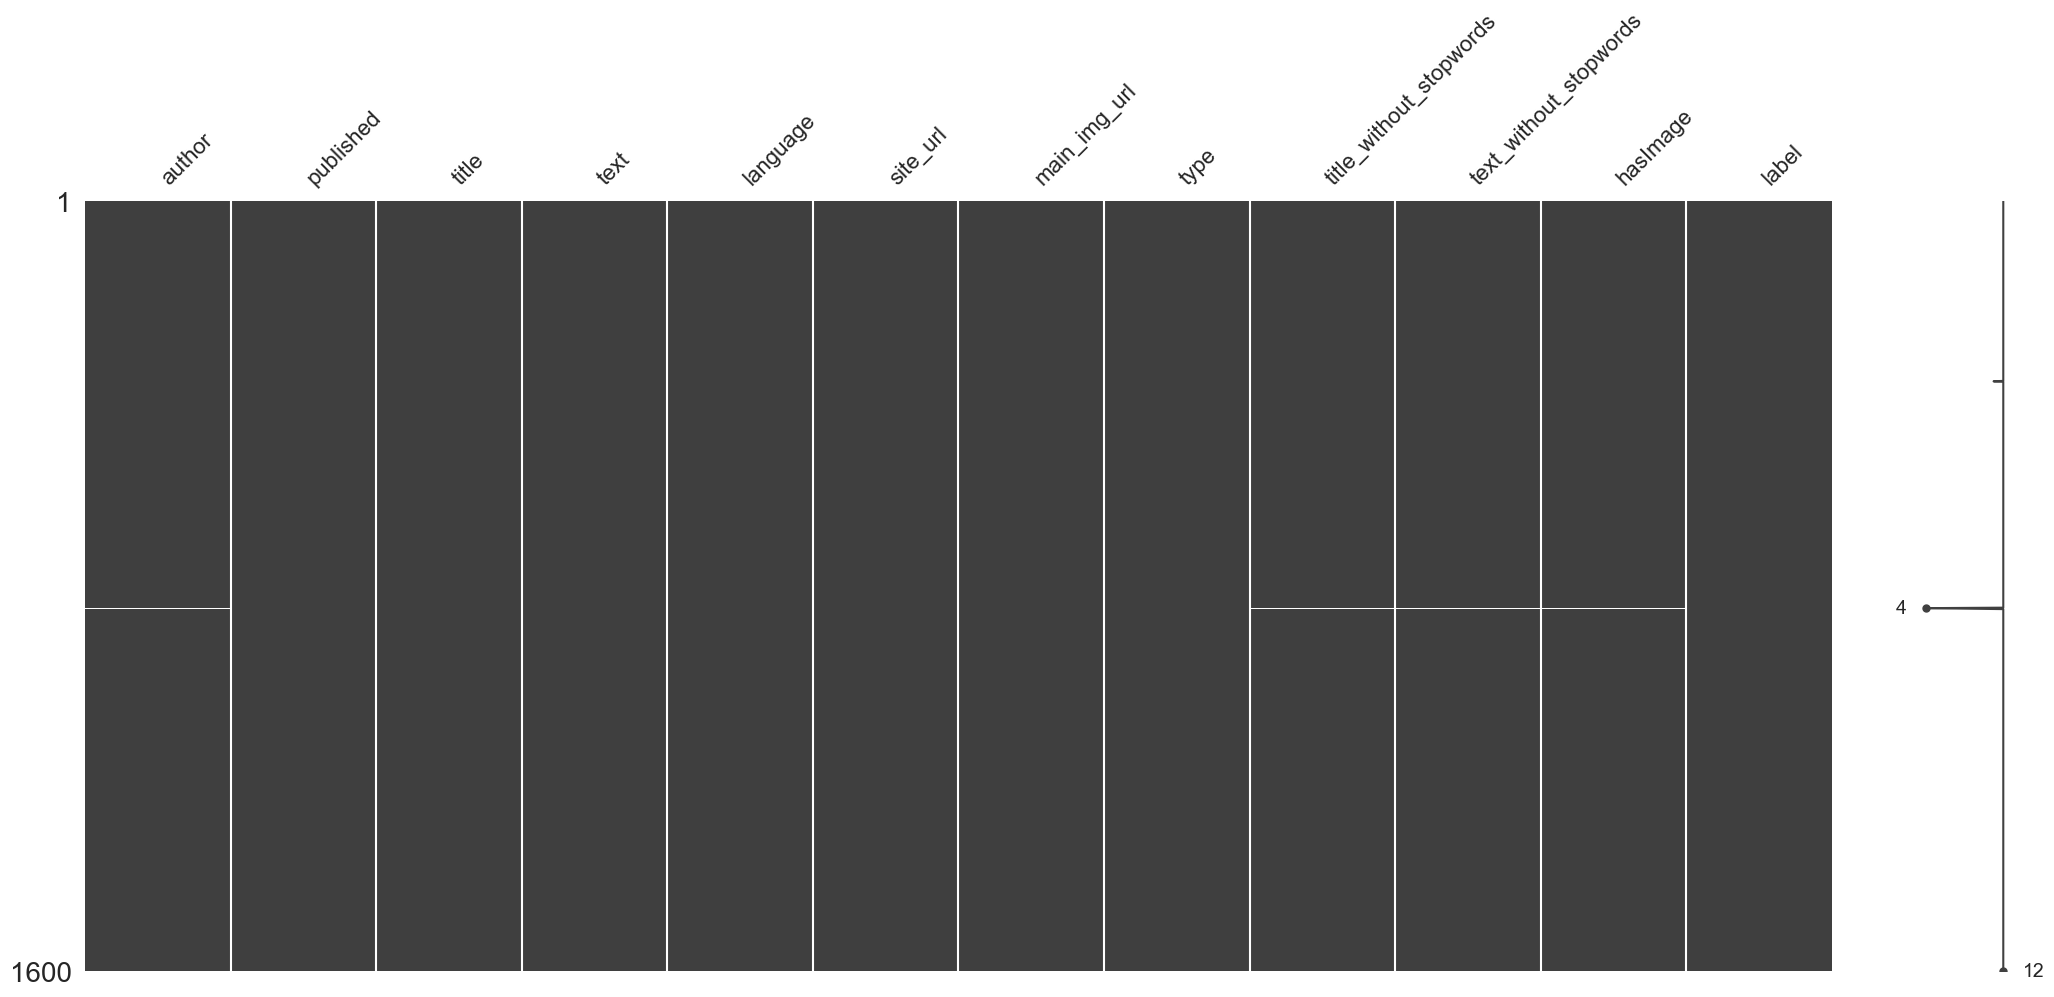

In [13]:
# Checking the areas and relationship between missing values
msno.matrix(raw_data)

The plot shows that some missing values occur together in particular row. Inspecting the missing data can help to determine how to handle these rows.

In [14]:
# Filtering rows with missing values
raw_data[raw_data.isna().any(axis=1)]

,author,published,title,text,language,site_url,main_img_url,type,title_without_stopwords,text_without_stopwords,hasImage,label
374,Daniel Haiphong,2016-11-17T02:00:00.000+02:00,won now what,the syrian army and hezbollah resistance force...,english,ahtribune.com,http://ahtribune.com/images/media/Donald_Trump...,bs,NaN,syrian army hezbollah resistance forces contin...,1.0,Fake
845,Dr. Patrick Slattery,2016-11-17T07:12:32.712+02:00,dr duke and pastor dankof quote jews boasting ...,views share by dr david duke when i was first...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
846,NaN,english,davidduke.com,http://davidduke.com/wp-content/uploads/2016/1...,hate,Real,dr duke pastor dankof quote jews boasting jewi...,httpmediaarchivesgsradionetddukemp dr duke mar...,NaN,NaN,NaN,1


The missing values cannot be replaced with appropriate values as this may affect the performance of the model. The number of rows with missing columns is less than 10% of the entire dataframe. Dropping these rows would have no effect in our analysis.

In [15]:
# Dropping rows with missing values
cleaned_data = raw_data.dropna()
cleaned_data.isnull().sum()

author                     0
published                  0
title                      0
text                       0
language                   0
site_url                   0
main_img_url               0
type                       0
title_without_stopwords    0
text_without_stopwords     0
hasImage                   0
label                      0
dtype: int64

### Checking the data types

In [16]:
# Checking the data types and information of the train data
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1597 entries, 0 to 1599
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   author                   1597 non-null   object 
 1   published                1597 non-null   object 
 2   title                    1597 non-null   object 
 3   text                     1597 non-null   object 
 4   language                 1597 non-null   object 
 5   site_url                 1597 non-null   object 
 6   main_img_url             1597 non-null   object 
 7   type                     1597 non-null   object 
 8   title_without_stopwords  1597 non-null   object 
 9   text_without_stopwords   1597 non-null   object 
 10  hasImage                 1597 non-null   float64
 11  label                    1597 non-null   object 
dtypes: float64(1), object(11)
memory usage: 162.2+ KB


In [17]:
# Converting to appropriate data types
cleaned_data = cleaned_data.convert_dtypes()

cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1597 entries, 0 to 1599
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   author                   1597 non-null   string
 1   published                1597 non-null   string
 2   title                    1597 non-null   string
 3   text                     1597 non-null   string
 4   language                 1597 non-null   string
 5   site_url                 1597 non-null   string
 6   main_img_url             1597 non-null   string
 7   type                     1597 non-null   string
 8   title_without_stopwords  1597 non-null   string
 9   text_without_stopwords   1597 non-null   string
 10  hasImage                 1597 non-null   Int64 
 11  label                    1597 non-null   string
dtypes: Int64(1), string(11)
memory usage: 163.8 KB


The columns have appropriate data types, however published contains datetime values and should be in datetime[ns] Dtype. 

In [18]:
# Convert the rows in the published columns to datetime dtype and see what columns have errors.
try:
    for i in cleaned_data.index:
        cleaned_data.loc[i]['published'] = pd.to_datetime(
            cleaned_data.loc[i]['published']
        )
except:
    print(i)

849


Row 849 has a content in the column resulting in a bug in the code. This row would require inspection to debug the error.

In [19]:
# Inspecting row 849
cleaned_data.loc[849]['published']

'http://davidduke.com/wp-content/uploads/2014/04/jucundus-Foxman.jpg'

The published column does not contain a datetime value and it would be difficult to accurate estimate the proper date. Therefore, the row will be dropped and the dataframe index will be reset to prevent index errors as row 849 would be skipped.

In [20]:
# Dropping row 849 and resetting index
cleaned_data = cleaned_data.drop(849).reset_index(drop=True)

In [32]:
# Converting the published column into the proper data type
cleaned_data['published'] = pd.to_datetime(cleaned_data['published'])

cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596 entries, 0 to 1595
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   author                   1596 non-null   string
 1   published                1596 non-null   object
 2   title                    1596 non-null   string
 3   text                     1596 non-null   string
 4   language                 1596 non-null   string
 5   site_url                 1596 non-null   string
 6   main_img_url             1596 non-null   string
 7   type                     1596 non-null   string
 8   title_without_stopwords  1596 non-null   string
 9   text_without_stopwords   1596 non-null   string
 10  hasImage                 1596 non-null   Int64 
 11  label                    1596 non-null   string
dtypes: Int64(1), object(1), string(10)
memory usage: 151.3+ KB


### Dropping duplicated rows

In [33]:
# Checking for duplicated rows in the train data
cleaned_data.duplicated(keep=False).sum()

17

In [34]:
# Show all rows that are duplicated in the training data
cleaned_data[cleaned_data.duplicated(keep=False)]

,author,published,title,text,language,site_url,main_img_url,type,title_without_stopwords,text_without_stopwords,hasImage,label
62,Anonymous,2016-10-26 22:35:00+03:00,no title,trump has an excuse now to audit any vote with...,english,abeldanger.net,No Image URL,bs,title,trump excuse audit vote machines trust un invo...,0,Fake
63,Anonymous,2016-10-26 22:19:00+03:00,no title,he has got to go after him he is the one caus...,english,abeldanger.net,No Image URL,bs,title,got go one causing al trouble around worl proo...,0,Fake
66,Anonymous,2016-10-26 22:35:00+03:00,no title,trump has an excuse now to audit any vote with...,english,abeldanger.net,No Image URL,bs,title,trump excuse audit vote machines trust un invo...,0,Fake
67,Anonymous,2016-10-26 22:19:00+03:00,no title,he has got to go after him he is the one caus...,english,abeldanger.net,No Image URL,bs,title,got go one causing al trouble around worl proo...,0,Fake
70,Anonymous,2016-10-27 21:50:00+03:00,no title,georg soros the good oil httpmailstarnetsoros...,english,abeldanger.net,No Image URL,bs,title,georg soros good oil httpmailstarnetsoroshtml ...,0,Fake
74,Anonymous,2016-10-27 21:50:00+03:00,no title,georg soros the good oil httpmailstarnetsoros...,english,abeldanger.net,No Image URL,bs,title,georg soros good oil httpmailstarnetsoroshtml ...,0,Fake
76,Anonymous,2016-10-27 21:50:00+03:00,no title,georg soros the good oil httpmailstarnetsoros...,english,abeldanger.net,No Image URL,bs,title,georg soros good oil httpmailstarnetsoroshtml ...,0,Fake
94,Anonymous,2016-10-29 22:36:00+03:00,no title,the second video bottom one proves what trump...,english,abeldanger.net,No Image URL,bs,title,second video bottom one proves trump sayng tru...,0,Fake
96,Anonymous,2016-10-29 22:36:00+03:00,no title,the second video bottom one proves what trump...,english,abeldanger.net,No Image URL,bs,title,second video bottom one proves trump sayng tru...,0,Fake
97,Anonymous,2016-10-29 22:25:00+03:00,no title,brilliant,english,abeldanger.net,No Image URL,bs,title,brilliant,0,Fake


There are multiple columns containing duplicated data. Dropping the duplicated rows will not affect the analysis. 

In [35]:
# Dropping duplicated rows
print(cleaned_data.shape)
cleaned_data = cleaned_data.drop_duplicates()
print(cleaned_data.shape)

(1596, 12)
(1586, 12)


### Checking for imbalance in the Label Column



In [36]:
# Checking the distribution of labelled data in the cleaned data
print(cleaned_data.label.value_counts())

print(cleaned_data['label'].value_counts(normalize=True))

label
Fake    1106
Real     480
Name: count, dtype: Int64
label
Fake    0.697352
Real    0.302648
Name: proportion, dtype: Float64


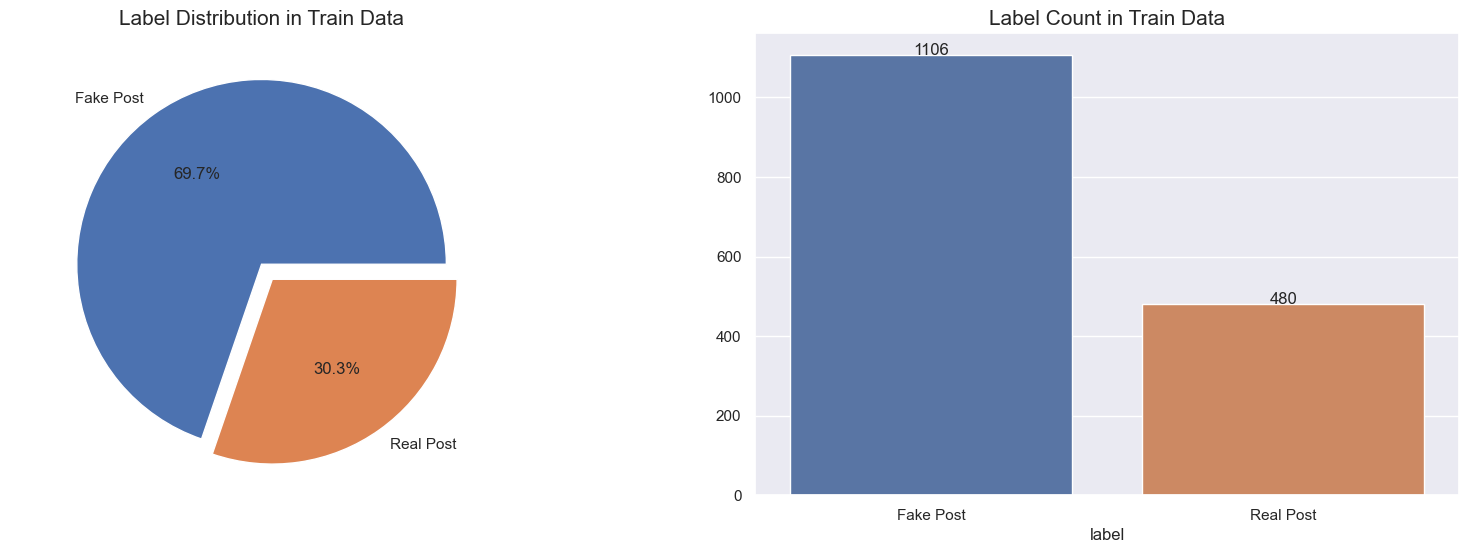

In [37]:
# Plotting the Label column to visualize the imbalance in the training data

f, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0] = (
    cleaned_data['label']
    .value_counts()
    .plot.pie(
        explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], labels=['Fake Post', 'Real Post']
    )
)

cleaned_data2 = cleaned_data["label"].value_counts()
ax[1] = sns.barplot(x=cleaned_data2.index, y=cleaned_data2, ax=ax[1])
ax[1].set_xticklabels(["Fake Post", "Real Post"])

ax[0].set_ylabel(' ')
ax[1].set_ylabel(' ')

ax[0].set_title('Label Distribution in Train Data', fontsize=15)
ax[1].set_title('Label Count in Train Data', fontsize=15)

for i, p in enumerate(ax[1].patches):
    height = p.get_height()
    ax[1].text(
        p.get_x() + p.get_width() / 2.0, height + 0.9, cleaned_data2[i], ha="center"
    )

plt.show()

The dataset is highly imbalanced as ratio of real posts to fake posts is 1:2.3

## Exploratory Data Analysis and Visualizations

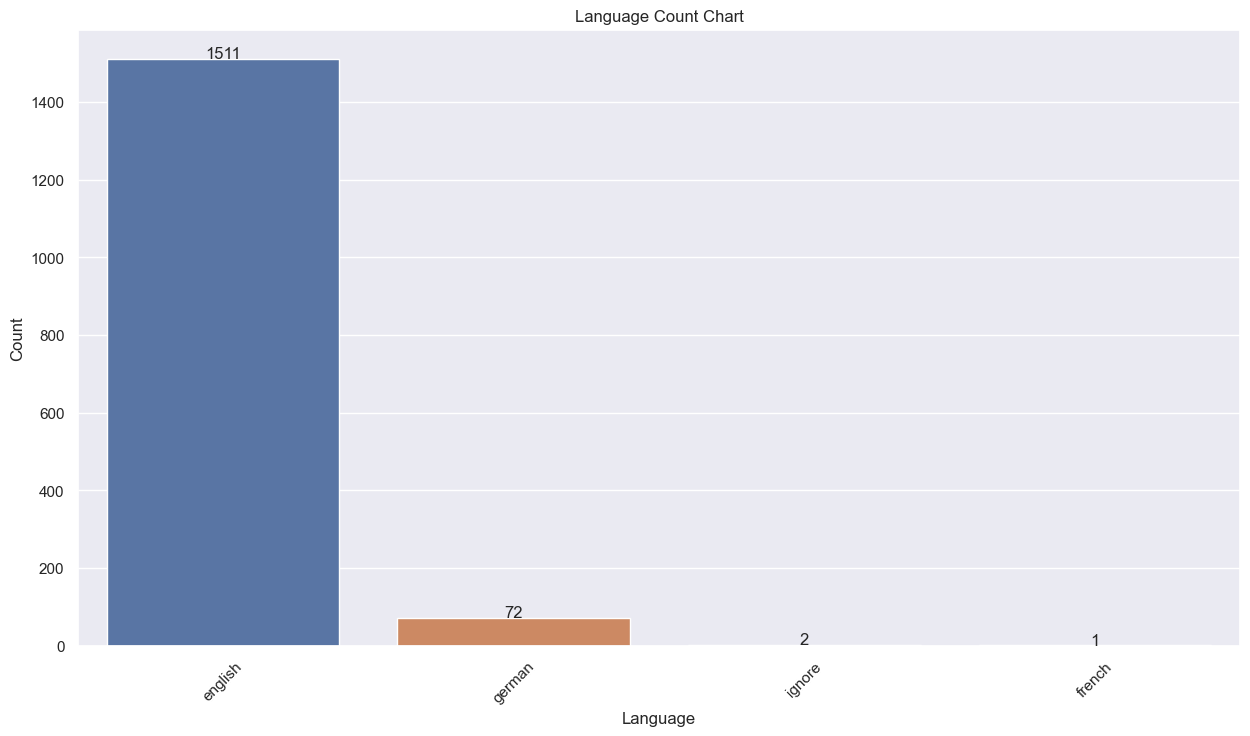

In [38]:
# Plotting a bar chart to show frequency of languages in a train data
labels = cleaned_data['language'].value_counts().index
values = cleaned_data['language'].value_counts().values
plt.figure(figsize=(15, 8))

ax = sns.barplot(x=labels, y=values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title("Language Count Chart")
plt.ylabel("Count")
plt.xlabel("Language")


for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.0, height + 0.9, values[i], ha="center")

News posts in the train data were mostly in English language has the highest frequency in the training data.

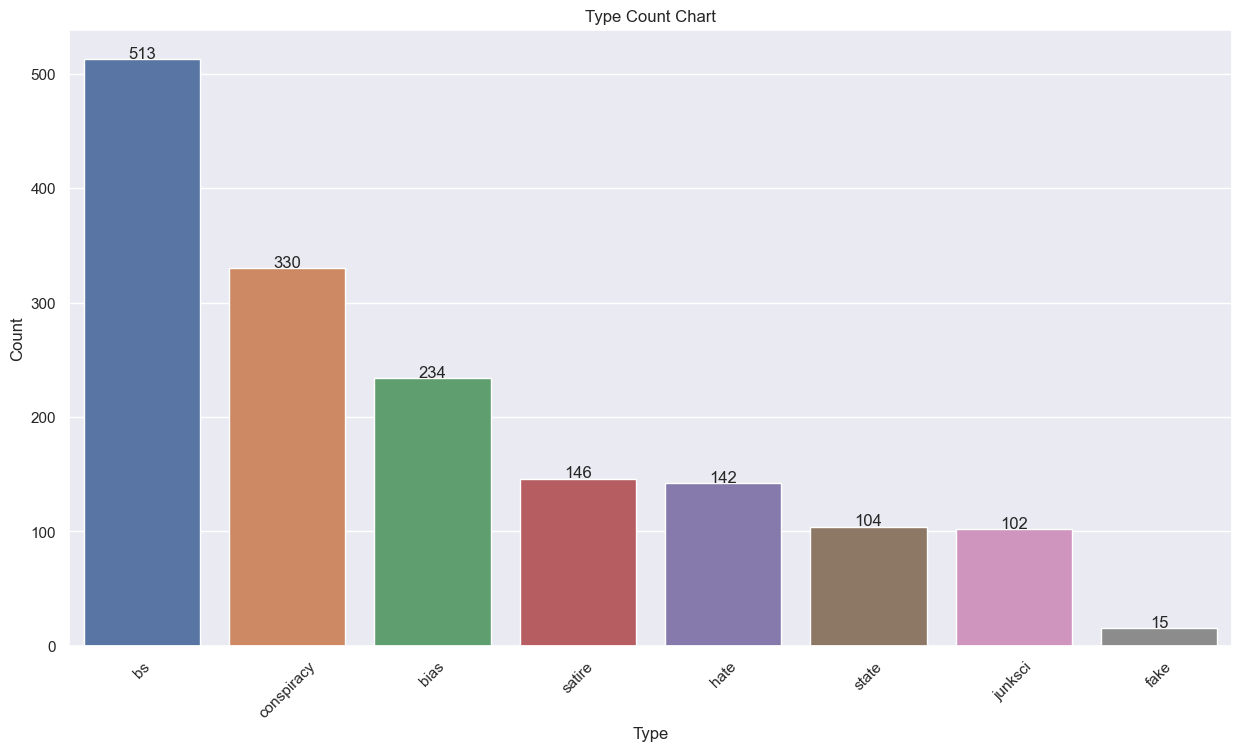

In [39]:
# Plotting a bar chart to show frequency of type in a train data
labels = cleaned_data['type'].value_counts().index
values = cleaned_data['type'].value_counts().values
plt.figure(figsize=(15, 8))

ax = sns.barplot(x=labels, y=values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title("Type Count Chart")
plt.ylabel("Count")
plt.xlabel("Type")


for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.0, height + 0.9, values[i], ha="center")

News posts with 'bs' type appeared mostly in the training data

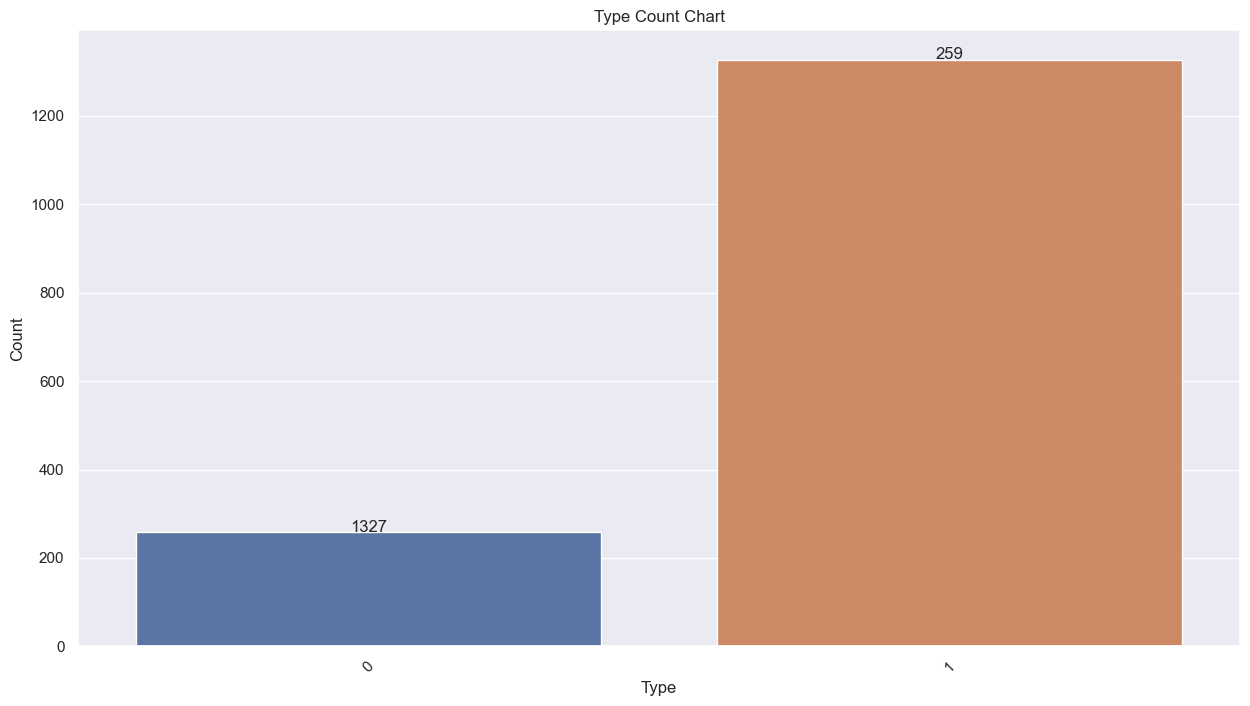

In [40]:
# Plotting a bar chart to show frequency of images in a train data
labels = cleaned_data['hasImage'].value_counts().index
values = cleaned_data['hasImage'].value_counts().values
plt.figure(figsize=(15, 8))

ax = sns.barplot(x=labels, y=values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title("Type Count Chart")
plt.ylabel("Count")
plt.xlabel("Type")


for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.0, height + 0.9, values[i], ha="center")

Most of the news posts had images attached

In [41]:
# a functon to create count plots of columns in the data set
def sns_countplot(feature):
    plt.figure(figsize=(20, 6))
    sns.countplot(
        x=feature,
        data=cleaned_data,
        hue="label",
        order=cleaned_data[feature].value_counts().index,
    )
    plt.xticks(rotation=45)
    title = feature.capitalize() + ' Distribution'

    plt.title(title)
    plt.show()

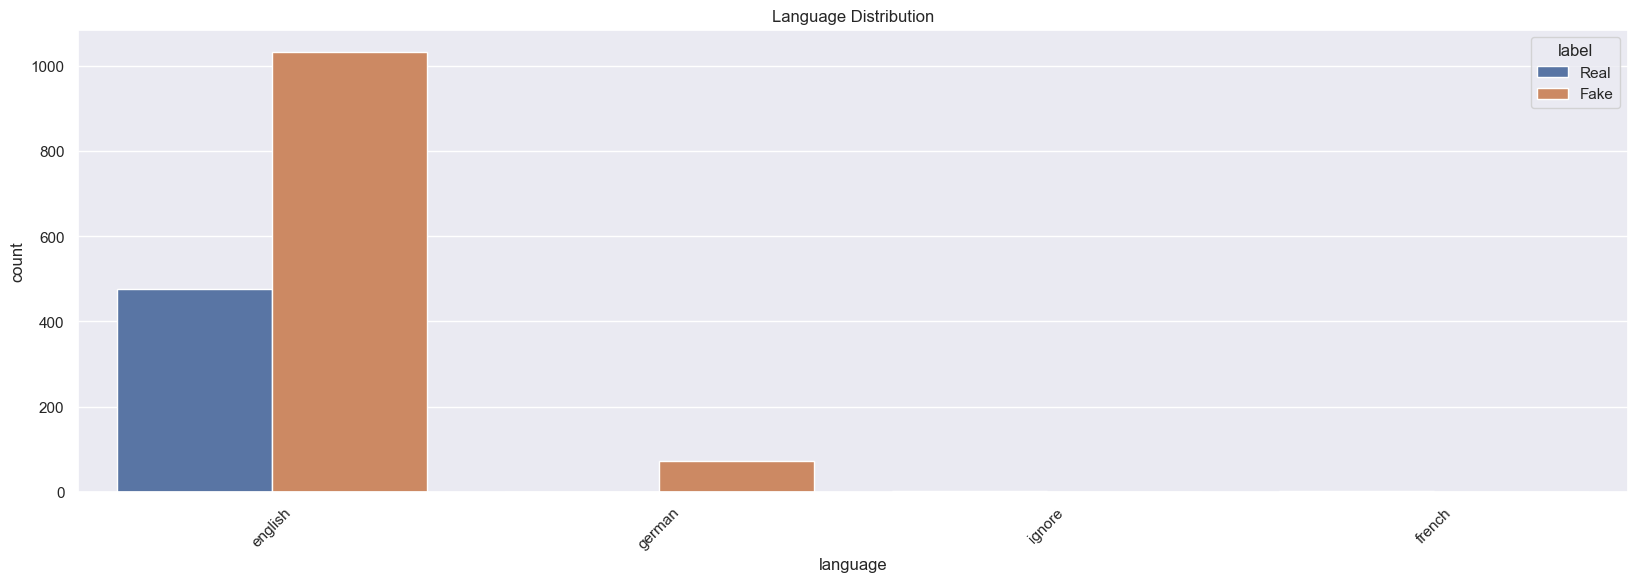

In [42]:
sns_countplot('language')

There are more real news posts when te language is in English than German and French

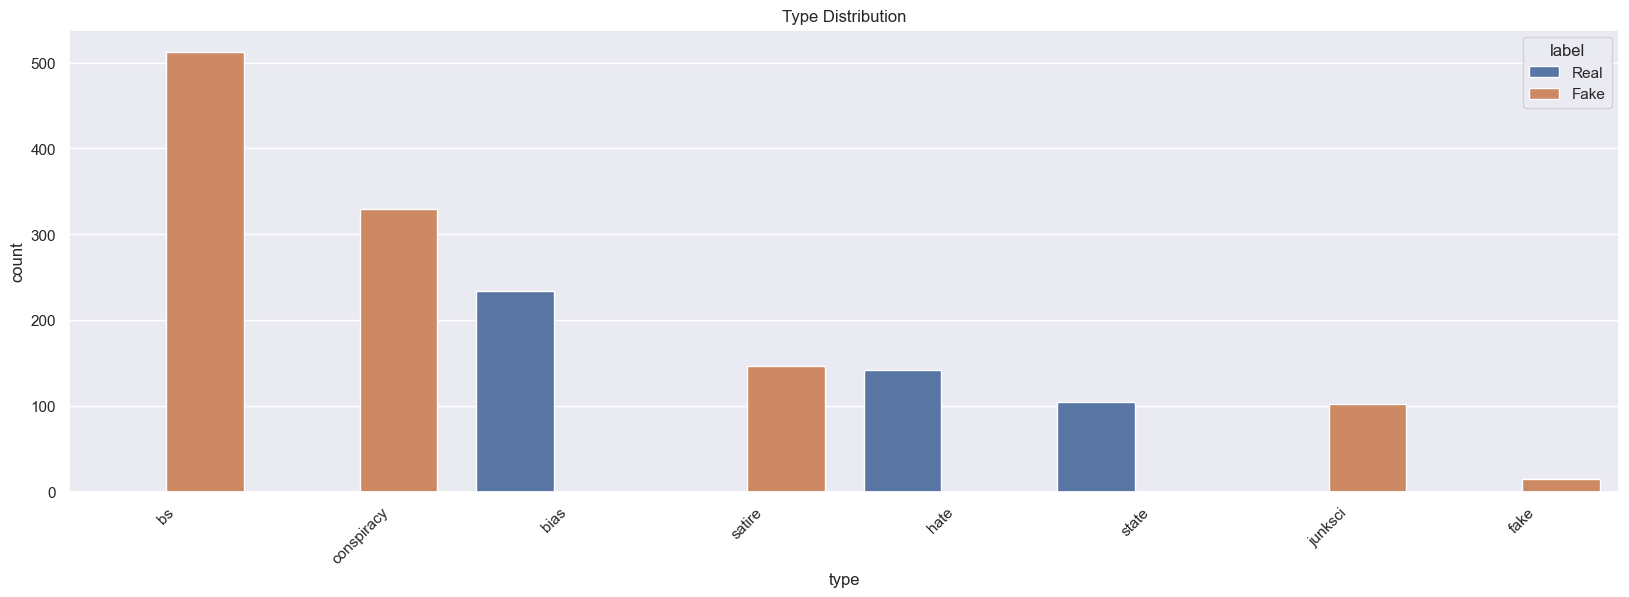

In [44]:
sns_countplot('type')

There are more real news with bias, hate, and state types. All other types were associated with fake news

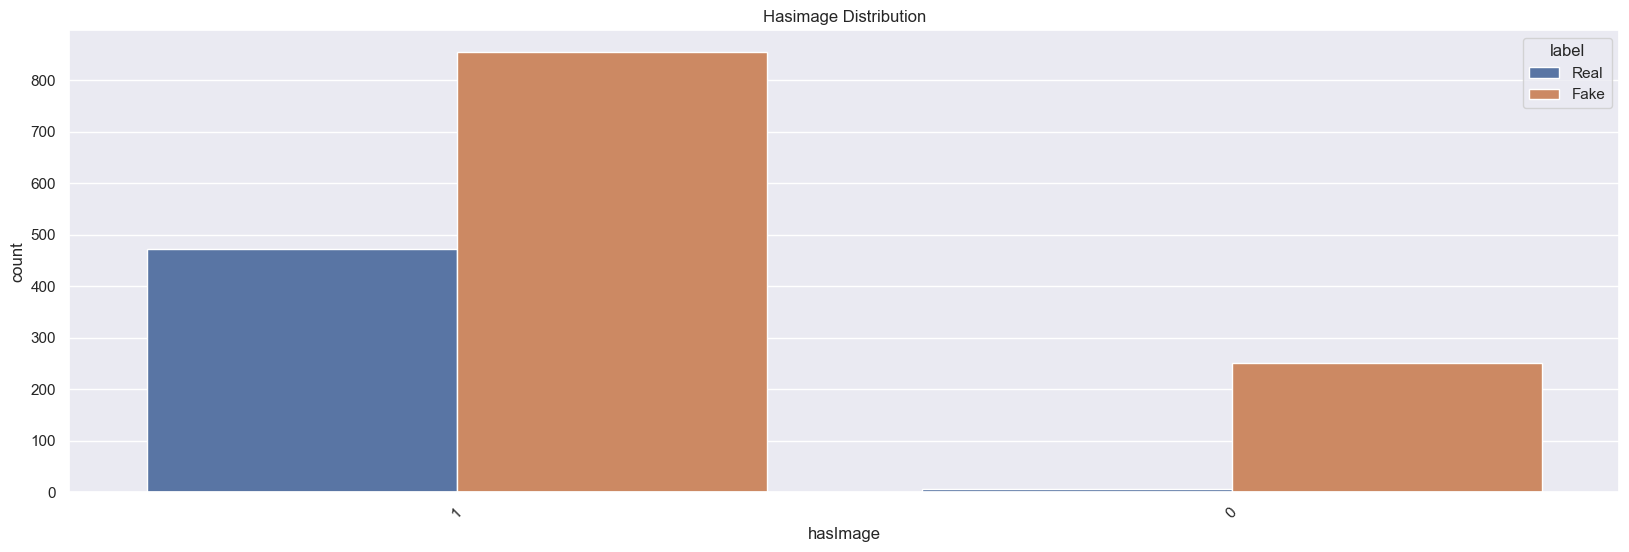

In [45]:
sns_countplot('hasImage')

News post with images is very likely to be real posts

## Textual Data Processing

In [221]:
# Concatenating revelant columns with textual information into a new dataframe and make a corpus
text_data = cleaned_data[
    [
        'author',
        'published',
        'title',
        'text',
        'language',
        'site_url',
        'main_img_url',
        'type',
        'hasImage',
        'label',
    ]
]

text_data['corpus'] = (
    text_data['author']
    + ' '
    + text_data['title']
    + ' '
    + text_data['text']
    + ' '
    + text_data['language']
    + ' '
    + text_data['site_url']
    + ' '
    + text_data['main_img_url']
    + ' '
    + text_data['type']
)

text_data['corpus'].head()

0    Barracuda Brigade muslims busted they stole mi...
1    reasoning with facts re why did attorney gener...
2    Barracuda Brigade breaking weiner cooperating ...
3    Fed Up pin drop speech by father of daughter k...
4    Fed Up fantastic trumps  point plan to reform ...
Name: corpus, dtype: string

In [47]:
text_data['corpus'].loc[text_data.label == 'Fake'].head()

33    No Author intl community still financing prote...
34    No Author fbi director comeys leaked memo expl...
35    Shawn Helton fbi redux whats behind new probe ...
36    Mike Rivero party corruption clinton campaign ...
37    No Author hillarys russian hack hoax the bigge...
Name: corpus, dtype: string

In [48]:
# Processing corpus with python methods and regex to remove stopwords, numbers, puntuations and non english characters

text_data['corpus'] = text_data['corpus'].str.lower()
stop = stopwords.words('english')
text_data['corpus'] = text_data['corpus'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in (stop)])
)
text_data['corpus'] = text_data['corpus'].str.replace(
    r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
    '',
)
text_data['corpus'] = text_data['corpus'].str.replace(r'[\'-]', '')
text_data['corpus'] = text_data['corpus'].str.replace(
    r'[\'\",()*&^%$#@!~`+=|/<>?{}\[\]\/\\:;\_]]', ' '
)
text_data['corpus'] = text_data['corpus'].apply(
    lambda x: ' '.join([word for word in x.split() if not word.startswith('url')])
)
text_data['corpus'] = text_data['corpus'].apply(
    lambda x: ' '.join([word for word in x.split(' ') if len(word) < 25])
)
text_data['corpus'] = text_data['corpus'].map(lambda x: re.sub(r'\W+', ' ', x))
text_data['corpus'] = text_data['corpus'].str.replace(r'[0-9]', '')
text_data['corpus'] = text_data['corpus'].str.replace(r'[^a-z]', ' ')
text_data['corpus'].head()

0    barracuda brigade muslims busted stole million...
1    reasoning facts attorney general loretta lynch...
2    barracuda brigade breaking weiner cooperating ...
3    fed pin drop speech father daughter kidnapped ...
4    fed fantastic trumps point plan reform healthc...
Name: corpus, dtype: object

In [49]:
# Further text processing with lemmatizing
lemmatizer = WordNetLemmatizer()


def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in word_tokenize(text)]


text_data['corpus'] = text_data['corpus'].apply(lemmatize_text)
text_data['corpus'] = [' '.join(map(str, l)) for l in text_data['corpus']]
text_data['corpus'].head()

0    barracuda brigade muslim busted stole million ...
1    reasoning fact attorney general loretta lynch ...
2    barracuda brigade breaking weiner cooperating ...
3    fed pin drop speech father daughter kidnapped ...
4    fed fantastic trump point plan reform healthca...
Name: corpus, dtype: object

In [50]:
# Calculating tharacter count for each text column
text_data['character_count'] = text_data['corpus'].apply(len)
text_data[['corpus', 'character_count']].head()

,corpus,character_count
0,barracuda brigade muslim busted stole million ...,410
1,reasoning fact attorney general loretta lynch ...,1354
2,barracuda brigade breaking weiner cooperating ...,1050
3,fed pin drop speech father daughter kidnapped ...,319
4,fed fantastic trump point plan reform healthca...,1609


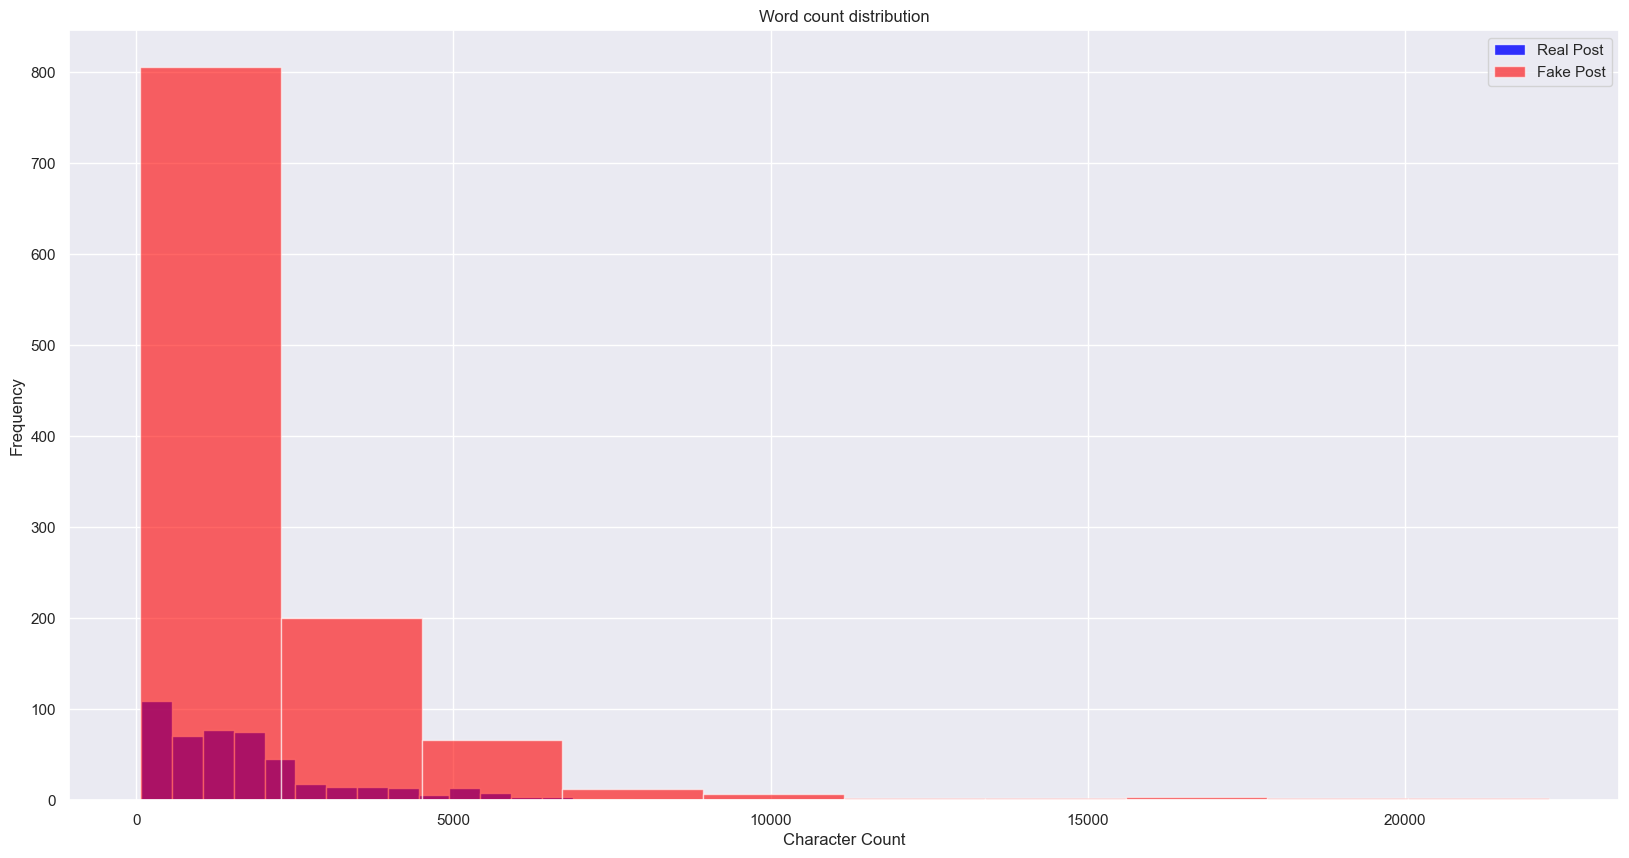

In [51]:
# Plotting a bar chart to display the distribution of words in both real posts and fake posts in association with their word count
plt.figure(figsize=(20, 10))
text_data[text_data.label == 'Real'].character_count.plot(
    bins=35, kind='hist', color='blue', label='Real Post', alpha=0.8
)
text_data[text_data.label == 'Fake'].character_count.plot(
    kind='hist', color='red', label='Fake Post', alpha=0.6
)
plt.legend()
plt.title('Word count distribution')
plt.xlabel("Character Count")

<Figure size 1500x800 with 0 Axes>

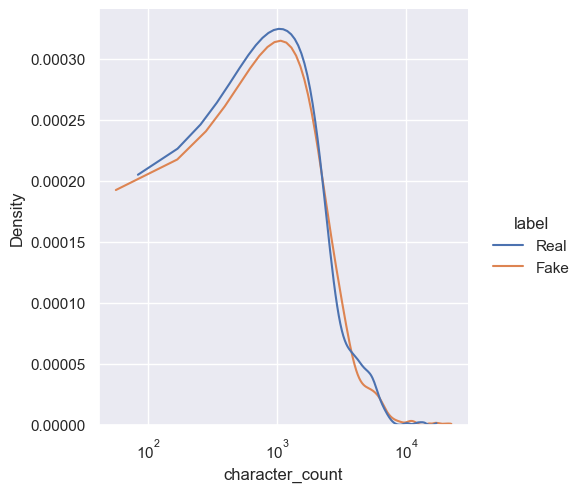

In [52]:
plt.figure(figsize=(15, 8))
ax = sns.displot(
    text_data, x='character_count', hue='label', kind='kde', common_norm=False, cut=0
)
ax.set(xscale="log")
plt.show()

From the plot, both real and fake posts have similar textual content

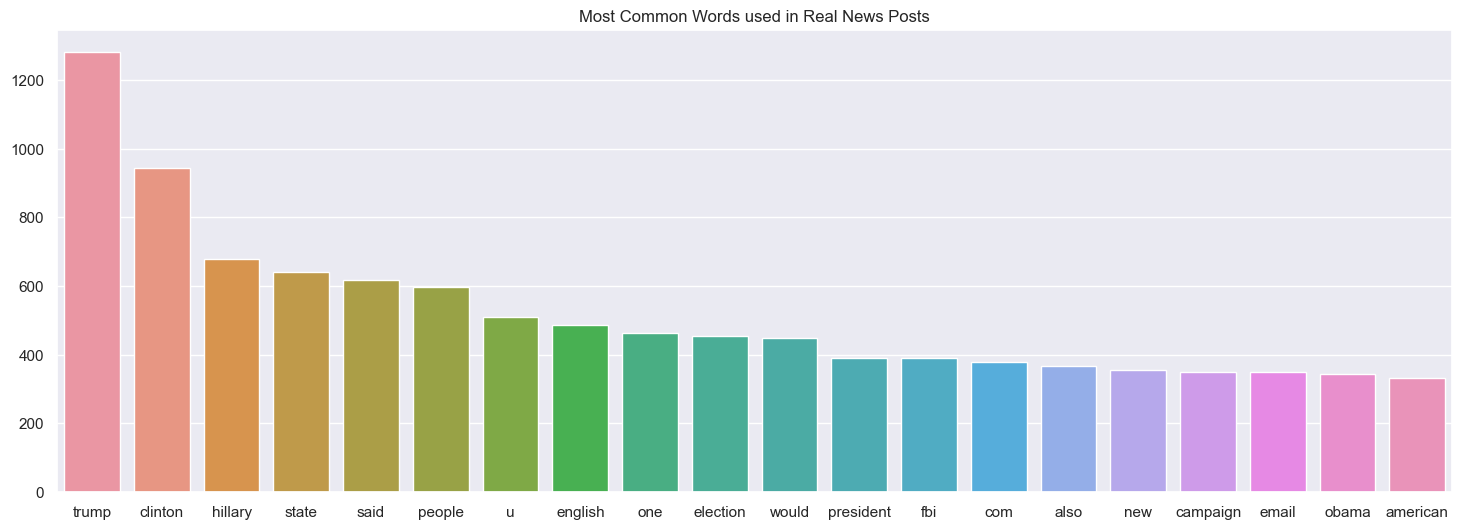

In [54]:
real_total_text = [text for text in text_data['corpus'].loc[text_data.label == 'Real']]
real_total_text = ' '.join(real_total_text).split()

real_counts = Counter(real_total_text)

real_common_words = [word[0] for word in real_counts.most_common(20)]
real_common_counts = [word[1] for word in real_counts.most_common(20)]

fig = plt.figure(figsize=(18, 6))
sns.barplot(x=real_common_words, y=real_common_counts)
plt.title('Most Common Words used in Real News Posts')
plt.show()

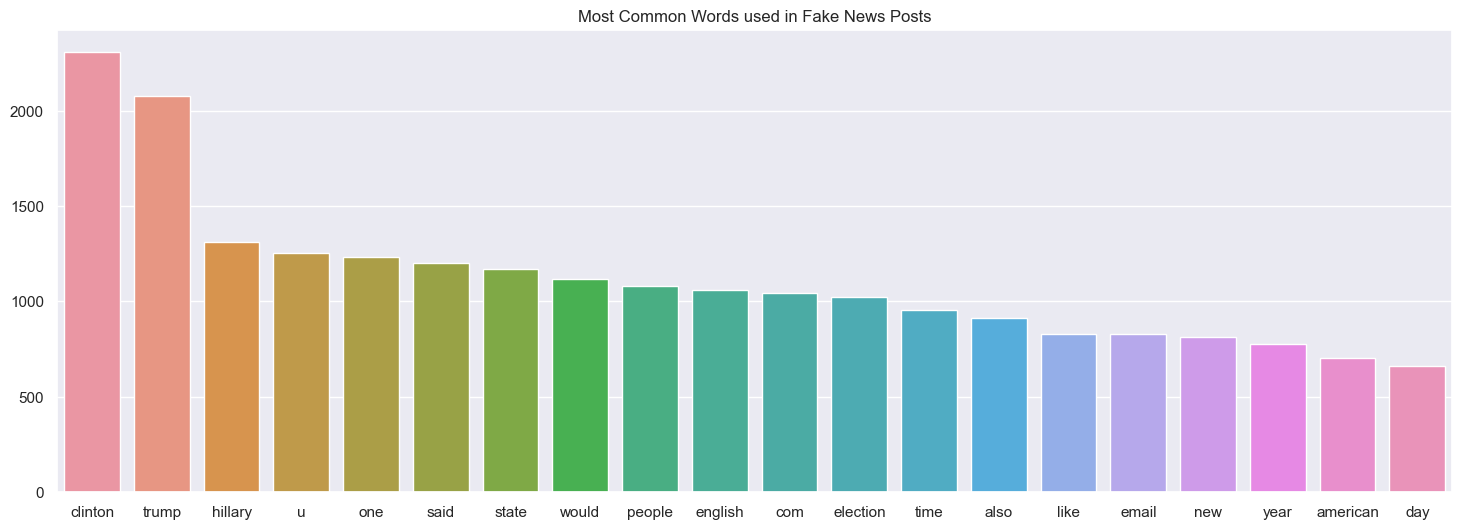

In [55]:
fake_total_text = [text for text in text_data['corpus'].loc[text_data.label == 'Fake']]
fake_total_text = ' '.join(fake_total_text).split()

fake_counts = Counter(fake_total_text)

fake_common_words = [word[0] for word in fake_counts.most_common(20)]
fake_common_counts = [word[1] for word in fake_counts.most_common(20)]

fig = plt.figure(figsize=(18, 6))
sns.barplot(x=fake_common_words, y=fake_common_counts)
plt.title('Most Common Words used in Fake News Posts')
plt.show()

The word cloud shows there is a lot of similarity in the words and frequency of used in real and fake posts. A number of words appear in both word clouds.

## Feature Engineering

In [237]:
# Selecting columns needed tp build the model
model_data = text_data[['label', 'corpus']].reset_index(drop=True)
model_data

,label,corpus
0,Real,Barracuda Brigade muslims busted they stole mi...
1,Real,reasoning with facts re why did attorney gener...
2,Real,Barracuda Brigade breaking weiner cooperating ...
3,Real,Fed Up pin drop speech by father of daughter k...
4,Real,Fed Up fantastic trumps point plan to reform ...
...,...,...
1581,Real,No Author iraqi forces score major gains south...
1582,Real,No Author us supreme court justice groped fema...
1583,Real,No Author trump vps plane slides off runway at...
1584,Real,No Author presstvrussia cancels request to fue...


In [238]:
# The label column needs to be encoded to be used by the model
dict = {'Real': '1', 'Fake': '0'}
model_data['label'] = model_data['label'].map(dict).astype(int)
model_data.head()

,label,corpus
0,1,Barracuda Brigade muslims busted they stole mi...
1,1,reasoning with facts re why did attorney gener...
2,1,Barracuda Brigade breaking weiner cooperating ...
3,1,Fed Up pin drop speech by father of daughter k...
4,1,Fed Up fantastic trumps point plan to reform ...


### Vectorizing the text data

In [58]:
# The corpus of text will be converted to vectors
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [59]:
# The initialized vectorizer is fitted to the corpus of text in the train data
vectorizer.fit(model_data['corpus'])

TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [60]:
# The vectorized train corpus is then transformed and placed in a variable
X = vectorizer.fit_transform(model_data['corpus']).toarray()  # independent
y = model_data['label']  # dependent

In [63]:
# The variable is placed in a dataframe for ease of processing
X = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())

In [66]:
# The train data is spilt into training anf validation set at a ratio of 80:20
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=15, stratify=y
)
X_train

,100percentfedup,100percentfedup com,21stcenturywire,21stcenturywire com,___,aab,aap,aaron,aaron sorkin,ab,...,zulu,zulu king,zum,zuma,zur,zurück,zwar,zwei,zwischen,über
1343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


### Hyperparameter Tuning

In [74]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("news-classification-experiment")

mlflow.xgboost.autolog()

In [97]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)

        model = xgb.XGBClassifier(**params)
        model = model.fit(X_train, y_train)

        # Predicting values for training and validation data, and getting prediction probabilities
        y_pred = model.predict(X_val)
        y_val_pred_proba = model.predict_proba(X_val)[:, 1]

        accuracy = accuracy_score(y_val, y_pred)
        # f_score = f1_score(y_val, y_pred)
        print("SCORE:", accuracy)
        # print("F1:", f_score)
        mlflow.log_metric("accuracy", accuracy)
        # mlflow.log_metric("f1_score", f_score)

    return {'loss': accuracy, 'status': STATUS_OK}

In [98]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'eval_metric': 'auc',
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'binary:logistic',
    'seed': 42,
}

best_result = fmin(
    fn=objective, space=search_space, algo=tpe.suggest, max_evals=50, trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

2023/07/29 15:44:46 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/8d44cb4d9ae3401bbe7fffa981ccb40e/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:44:50 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:44:53 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                
1.0                                                   
  2%|▏         | 1/50 [00:27<22:28, 27.51s/trial, best loss: 1.0]

2023/07/29 15:45:16 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/5ef931d92d4f429d91431d833842625d/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:45:19 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:45:22 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                           
0.9905660377358491                                               
  4%|▍         | 2/50 [00:56<22:44, 28.44s/trial, best loss: 0.9905660377358491]

2023/07/29 15:45:43 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/2a6acc456a354e7daf1df97a9e903200/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:45:46 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:45:49 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                          
0.9874213836477987                                                              
  6%|▌         | 3/50 [01:24<21:57, 28.04s/trial, best loss: 0.9874213836477987]

2023/07/29 15:46:12 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/a94ae29047b94dab9d4e8fcf8135e5fa/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:46:15 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:46:19 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                          
0.9968553459119497                                                              
  8%|▊         | 4/50 [01:53<21:49, 28.46s/trial, best loss: 0.9874213836477987]

2023/07/29 15:46:46 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/4354984809d648f6a1907186acf2479f/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:46:49 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:46:52 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                          
1.0                                                                             
 10%|█         | 5/50 [02:27<22:46, 30.37s/trial, best loss: 0.9874213836477987]

2023/07/29 15:47:17 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/79a9f4790d134fd29c32afdc94f159d1/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:47:21 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:47:24 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                          
1.0                                                                             
 12%|█▏        | 6/50 [02:59<22:43, 30.98s/trial, best loss: 0.9874213836477987]

2023/07/29 15:47:56 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/6a82315f61254fc5a628cedd0f3918fd/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:47:59 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:48:01 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                          
1.0                                                                             
 14%|█▍        | 7/50 [03:35<23:32, 32.86s/trial, best loss: 0.9874213836477987]

2023/07/29 15:48:28 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/60db3bbbd664494991f3f88bd486160b/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:48:31 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:48:33 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                          
1.0                                                                             
 16%|█▌        | 8/50 [04:07<22:45, 32.51s/trial, best loss: 0.9874213836477987]

2023/07/29 15:48:56 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/3904e0ba79534d329ed35b74a80f44e4/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:48:58 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:49:01 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                          
1.0                                                                             
 18%|█▊        | 9/50 [04:35<21:15, 31.10s/trial, best loss: 0.9874213836477987]

2023/07/29 15:49:24 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/f8b91775ef974d3cad3e4e6ed1ce2138/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:49:27 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:49:30 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                          
0.9874213836477987                                                              
 20%|██        | 10/50 [05:04<20:17, 30.43s/trial, best loss: 0.9874213836477987]

2023/07/29 15:49:53 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/6f69a7f13f8f46f592e4f0caa9d4469f/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:49:56 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:49:59 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9811320754716981                                                               
 22%|██▏       | 11/50 [05:33<19:29, 30.00s/trial, best loss: 0.9811320754716981]

2023/07/29 15:50:22 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/996e704a35a446538e1997d9915b9cfd/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:50:25 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:50:28 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9811320754716981                                                               
 24%|██▍       | 12/50 [06:02<18:44, 29.59s/trial, best loss: 0.9811320754716981]

2023/07/29 15:50:50 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/0a9cbf5c726a4d9f81433594dc4988da/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:50:52 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:50:55 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9968553459119497                                                               
 26%|██▌       | 13/50 [06:29<17:46, 28.82s/trial, best loss: 0.9811320754716981]

2023/07/29 15:51:15 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/9dd68e2a321f491ba14838b676930d45/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:51:17 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:51:20 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9811320754716981                                                               
 28%|██▊       | 14/50 [06:54<16:39, 27.78s/trial, best loss: 0.9811320754716981]

2023/07/29 15:51:38 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/73635559243445d7b827e6c5ea5338a8/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:51:41 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:51:43 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
1.0                                                                              
 30%|███       | 15/50 [07:17<15:24, 26.42s/trial, best loss: 0.9811320754716981]

2023/07/29 15:52:08 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/7fdeb11410e648ff96430bca749231bb/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:52:11 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:52:14 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
1.0                                                                              
 32%|███▏      | 16/50 [07:48<15:38, 27.61s/trial, best loss: 0.9811320754716981]

2023/07/29 15:52:37 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/cadb010be3bf4e709e9d5c1e16aa2fe0/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:52:39 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:52:42 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9937106918238994                                                               
 34%|███▍      | 17/50 [08:16<15:18, 27.83s/trial, best loss: 0.9811320754716981]

2023/07/29 15:53:08 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/da19e528cef74dbf8fefb486c5b90943/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:53:11 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:53:15 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9968553459119497                                                               
 36%|███▌      | 18/50 [08:49<15:41, 29.43s/trial, best loss: 0.9811320754716981]

2023/07/29 15:53:43 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/cb32fa62b438440caf77350536ff6796/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:53:48 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:53:53 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9842767295597484                                                               
 38%|███▊      | 19/50 [09:27<16:28, 31.90s/trial, best loss: 0.9811320754716981]

2023/07/29 15:54:19 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/333e129eab014776ae2ba8a9a12e4c34/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:54:23 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:54:29 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
1.0                                                                              
 40%|████      | 20/50 [10:03<16:33, 33.12s/trial, best loss: 0.9811320754716981]

2023/07/29 15:55:04 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/efae19079d0f4f78979a341d7a7a7954/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:55:10 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:55:17 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9842767295597484                                                               
 42%|████▏     | 21/50 [10:51<18:14, 37.74s/trial, best loss: 0.9811320754716981]

2023/07/29 15:55:47 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/e07824f4077c47e78fdb864c2f514fd9/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:55:51 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:55:55 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9842767295597484                                                               
 44%|████▍     | 22/50 [11:29<17:36, 37.73s/trial, best loss: 0.9811320754716981]

2023/07/29 15:56:22 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/980764c06ab94dea97cebd5b6ac50f0f/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:56:26 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:56:30 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9748427672955975                                                               
 46%|████▌     | 23/50 [12:04<16:36, 36.92s/trial, best loss: 0.9748427672955975]

2023/07/29 15:56:55 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/d18b8555b947440f926583423f495a09/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:56:59 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:57:03 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9874213836477987                                                               
 48%|████▊     | 24/50 [12:37<15:26, 35.62s/trial, best loss: 0.9748427672955975]

2023/07/29 15:57:30 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/a93714b5b3c24f4da10edf162a8f3534/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:57:34 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:57:38 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9591194968553459                                                               
 50%|█████     | 25/50 [13:13<14:51, 35.65s/trial, best loss: 0.9591194968553459]

2023/07/29 15:58:05 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/7507a1a2e76b4331b764f2cb2daa2484/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:58:09 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:58:13 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
1.0                                                                              
 52%|█████▏    | 26/50 [13:48<14:12, 35.50s/trial, best loss: 0.9591194968553459]

2023/07/29 15:58:41 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/881d75b9ad644028840c7840af28d343/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:58:44 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:58:47 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9748427672955975                                                               
 54%|█████▍    | 27/50 [14:21<13:21, 34.83s/trial, best loss: 0.9591194968553459]

2023/07/29 15:59:12 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/cb12964b303c4b92af759165dcaf9adc/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:59:15 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:59:19 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9842767295597484                                                               
 56%|█████▌    | 28/50 [14:53<12:26, 33.95s/trial, best loss: 0.9591194968553459]

2023/07/29 15:59:44 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/de3aecae22d94f5eb4a6e4cb98369613/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 15:59:47 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 15:59:50 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9811320754716981                                                               
 58%|█████▊    | 29/50 [15:24<11:36, 33.14s/trial, best loss: 0.9591194968553459]

2023/07/29 16:00:15 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/dfb1a87db90743fab433d32c49c87ddc/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:00:18 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:00:21 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9905660377358491                                                               
 60%|██████    | 30/50 [15:55<10:50, 32.51s/trial, best loss: 0.9591194968553459]

2023/07/29 16:05:54 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/8d31da98eb164bfc8a3108218c9d3946/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:05:57 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:06:00 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
1.0                                                                              
 62%|██████▏   | 31/50 [21:34<39:25, 124.49s/trial, best loss: 0.9591194968553459]

2023/07/29 16:06:26 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/07a879d60883404ea62aa8339240d894/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:06:28 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:06:30 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                            
0.9811320754716981                                                                
 64%|██████▍   | 32/50 [22:05<28:52, 96.27s/trial, best loss: 0.9591194968553459] 

2023/07/29 16:06:51 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/0ed79564581d4f87ad210fca1c1758d0/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:06:54 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:06:56 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9874213836477987                                                               
 66%|██████▌   | 33/50 [22:31<21:17, 75.16s/trial, best loss: 0.9591194968553459]

2023/07/29 16:07:18 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/c4b95c2ceadd48af9b0b99da487b9d71/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:07:21 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:07:23 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9968553459119497                                                               
 68%|██████▊   | 34/50 [22:57<16:10, 60.65s/trial, best loss: 0.9591194968553459]

2023/07/29 16:07:46 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/c96992648dbd4773aa64c7c399ff9e16/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:07:48 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:07:51 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9842767295597484                                                               
 70%|███████   | 35/50 [23:25<12:42, 50.83s/trial, best loss: 0.9591194968553459]

2023/07/29 16:08:12 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/5cc4ee47d60b4533a1ed6ea1ee3ebcd2/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:08:15 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:08:17 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9874213836477987                                                               
 72%|███████▏  | 36/50 [23:51<10:06, 43.35s/trial, best loss: 0.9591194968553459]

2023/07/29 16:08:39 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/9e2c1c2f10744311b14d9e105a6a7af5/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:08:42 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:08:44 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9874213836477987                                                               
 74%|███████▍  | 37/50 [24:18<08:20, 38.47s/trial, best loss: 0.9591194968553459]

2023/07/29 16:09:06 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/5f6879cefa4d4c318968400de598a57d/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:09:09 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:09:11 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9937106918238994                                                               
 76%|███████▌  | 38/50 [24:46<07:01, 35.14s/trial, best loss: 0.9591194968553459]

2023/07/29 16:19:05 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/a65e95d5d1b54e7eaff9218b33fcfa70/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:19:09 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:19:15 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9622641509433962                                                               
 78%|███████▊  | 39/50 [34:49<37:41, 205.58s/trial, best loss: 0.9591194968553459]

2023/07/29 16:19:51 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/01b81b39469e40f38079220664c1365c/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:19:56 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:20:00 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                            
1.0                                                                               
 80%|████████  | 40/50 [35:34<26:15, 157.55s/trial, best loss: 0.9591194968553459]

2023/07/29 16:20:27 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/b01d15e9459644f1be20e9e95edeb795/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:20:31 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:20:35 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                            
1.0                                                                               
 82%|████████▏ | 41/50 [36:09<18:05, 120.59s/trial, best loss: 0.9591194968553459]

2023/07/29 16:21:00 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/999758032c4343b99320410a6af87abb/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:21:05 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:21:08 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                            
0.9842767295597484                                                                
 84%|████████▍ | 42/50 [36:43<12:36, 94.55s/trial, best loss: 0.9591194968553459] 

2023/07/29 16:21:33 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/8201219b540441349e5c28c022543dc6/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:21:37 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:21:41 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
1.0                                                                              
 86%|████████▌ | 43/50 [37:15<08:51, 75.96s/trial, best loss: 0.9591194968553459]

2023/07/29 16:22:03 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/e907398b04184c78a425bb6c4250e797/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:22:06 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:22:09 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9874213836477987                                                               
 88%|████████▊ | 44/50 [37:44<06:10, 61.73s/trial, best loss: 0.9591194968553459]

2023/07/29 16:22:40 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/bf2745b6eab4482f8ceb1f8ce3081446/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:22:42 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:22:45 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9937106918238994                                                               
 90%|█████████ | 45/50 [38:19<04:29, 53.93s/trial, best loss: 0.9591194968553459]

2023/07/29 16:23:08 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/39339ed1d415484790e0c1d21ab406dc/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:23:11 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:23:13 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9811320754716981                                                               
 92%|█████████▏| 46/50 [38:47<03:04, 46.16s/trial, best loss: 0.9591194968553459]

2023/07/29 16:23:36 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/25e34d6c31df4cc09d37d94ef74edd6d/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:23:39 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:23:42 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
1.0                                                                              
 94%|█████████▍| 47/50 [39:16<02:02, 40.97s/trial, best loss: 0.9591194968553459]

2023/07/29 16:24:05 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/a31ffe98c6bc491eb8b419d7dce8f9a0/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:24:08 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:24:10 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9811320754716981                                                               
 96%|█████████▌| 48/50 [39:45<01:14, 37.20s/trial, best loss: 0.9591194968553459]

2023/07/29 16:24:35 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/ef8b4f4be9b941a18ea1bddb7123fa19/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:24:38 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:24:40 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9968553459119497                                                               
 98%|█████████▊| 49/50 [40:14<00:34, 34.94s/trial, best loss: 0.9591194968553459]

2023/07/29 16:25:03 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under file:///c:/Users/ologa/OneDrive/Documents/lightsonheights/mlruns/1/3f798049f97c4eb4bb9a6656834ac7e9/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.

2023/07/29 16:25:06 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535

2023/07/29 16:25:08 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: Dataset schema exceeds the maximum length of 65535



SCORE:                                                                           
0.9842767295597484                                                               
100%|██████████| 50/50 [40:42<00:00, 48.86s/trial, best loss: 0.9591194968553459]


Tuning XGBoost 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       1.00      1.00      1.00        96

    accuracy                           1.00       318
   macro avg       1.00      1.00      1.00       318
weighted avg       1.00      1.00      1.00       318

Execution time: 15.659897498289745 min


Text(30.5, 0.5, 'Truth')

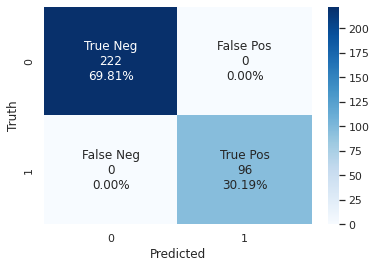

In [ ]:
xgb_report = classification_report(y_val, y_predict_xgb)
print(xgb_report)
print("Execution time: %s min" % ((end_time - start_time) / 60))

# making a confusion matrix
cf_matrix = confusion_matrix(y_val, y_predict_xgb)
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = [
    "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
]
labels = [
    f'{v1}\n{v2}\n{v3}'
    for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')

The f1 score for XGBoost is 100% for both classes

### Training the selected Model

The tuned Random Forest Model will be trained using the full data with all features

In [ ]:
start_time = time.time()
model = XGBClassifier(
    learning_rate=0.1,
    objective='binary:logistic',
    silent=True,
    nthread=1,
    max_depth=2,
    min_samples_split=200,
)
model.fit(X_res, y_res)
y_predict_model = model.predict(X_val)
end_time = time.time()

[10:20:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_samples_split", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [109]:
# Querying mlflow api instead of using web UI. Sorting by validation aucroc and then getting top run for best run.
EXPERIMENT_ID = mlflow.get_experiment_by_name(
    'news-classification-experiment'
).experiment_id
runs_df = mlflow.search_runs(
    experiment_ids=EXPERIMENT_ID, order_by=['metrics.accuracy DESC']
)
best_run = runs_df.iloc[0]
best_run_id = best_run['run_id']
best_artifact_uri = best_run['artifact_uri']
# Loading model from best run
best_model = mlflow.xgboost.load_model('runs:/' + best_run_id + '/model')
y_predict_model = best_model.predict(X_val)
# Predicting and evaluating best model on holdout set

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       222
           1       1.00      1.00      1.00        96

    accuracy                           1.00       318
   macro avg       1.00      1.00      1.00       318
weighted avg       1.00      1.00      1.00       318



Text(47.25, 0.5, 'Truth')

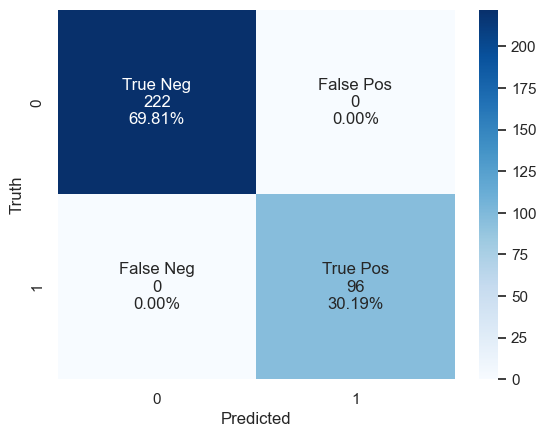

In [111]:
model_report = classification_report(y_val, y_predict_model)
print(model_report)
# print("Execution time: %s min" % ((end_time - start_time)/60))

# making a confusion matrix
cf_matrix = confusion_matrix(y_val, y_predict_model)
group_names = ["True Neg", "False Pos", "False Neg", "True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = [
    "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
]
labels = [
    f'{v1}\n{v2}\n{v3}'
    for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')

The performance is still above 99% for both classification.

AUC_SCORE: 1.0


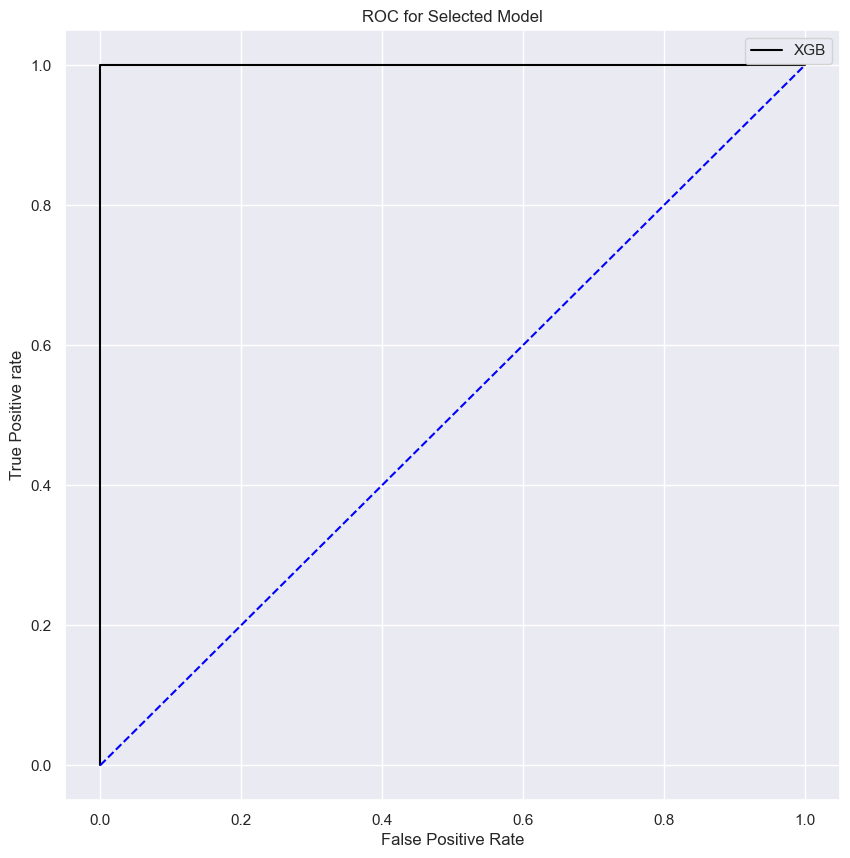

In [114]:
# Plotting the area under the curve to visualize the performance of the model

pred_prob = best_model.predict_proba(X_val)[:, 1]
fpr, tpr, thresh = roc_curve(y_val, pred_prob, pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_val))]
p_fpr, p_tpr, _ = roc_curve(y_val, random_probs, pos_label=1)

auc_score = roc_auc_score(y_val, pred_prob)
print("AUC_SCORE:", auc_score)

# plot roc curves

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, linestyle='solid', color='black', label='XGB')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')

# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')
plt.title('ROC for Selected Model')
plt.legend(loc='best')
plt.show()

The area under the curve (AUC) is 99.99% of the total area. The model can distingush news post that are real or fake with 99.99% accuracy.

In [115]:
model_details = mlflow.register_model(
    f'runs:/{best_run_id}/artifacts/model', 'NewsClassification-XGBHP'
)

Successfully registered model 'NewsClassification-XGBHP'.
2023/07/29 17:06:11 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: NewsClassification-XGBHP, version 1
Created version '1' of model 'NewsClassification-XGBHP'.


### Model Feature Importance

Inspecting the features being used to make predictions will help us understand how the model is classifying news posts.

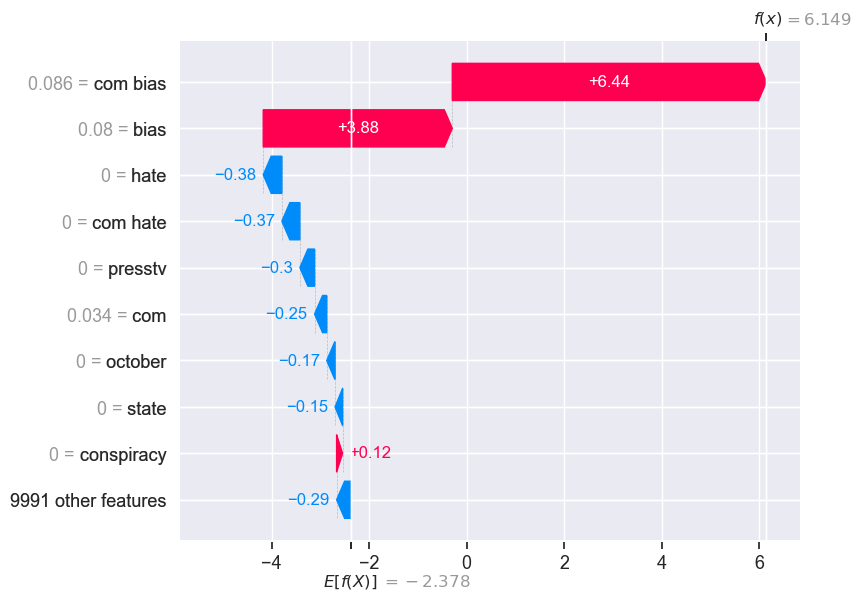

In [239]:
# Using shap library to extract features and their weights
explainer = shap.Explainer(best_model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [240]:
# visualize the training set predictions
shap.plots.force(shap_values)

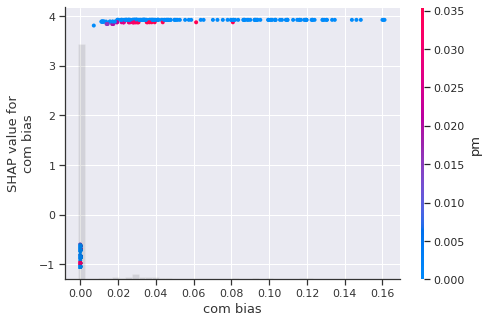

In [ ]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, "com bias"], color=shap_values)

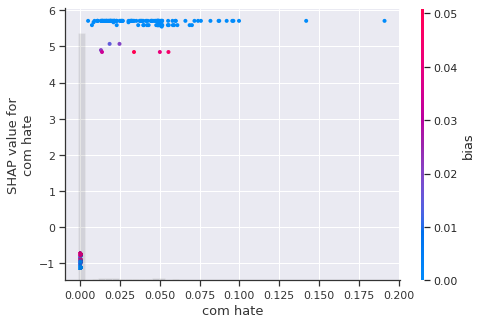

In [ ]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, "com hate"], color=shap_values)

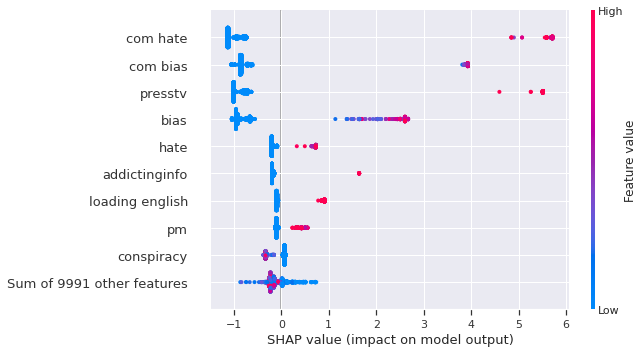

In [ ]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

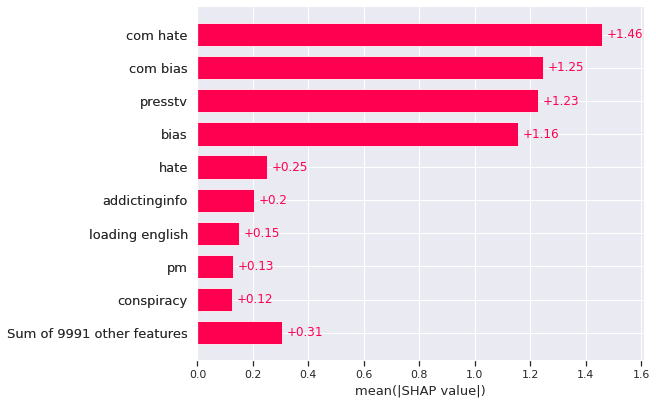

In [ ]:
shap.plots.bar(shap_values)

Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. 'bias' seems to be a major contributing factors to prediction of real news. 'hate' and 'presstv' also contributes to the prediction for fake news.

## Classifying the test data using the model

The test data will be laballed using the model and saved as an excel file.

In [126]:
# Checking for missing values in the test data

test_data.isnull().sum()

author                      0
published                   0
title                       0
text                       46
language                    1
site_url                    1
main_img_url                1
type                        1
title_without_stopwords     1
text_without_stopwords     50
hasImage                    1
dtype: int64

In [127]:
test_data.shape

(497, 11)

In [128]:
# All missing values will be replaced with an empty string

test_data = test_data.fillna("")
test_data.isnull().sum()

author                     0
published                  0
title                      0
text                       0
language                   0
site_url                   0
main_img_url               0
type                       0
title_without_stopwords    0
text_without_stopwords     0
hasImage                   0
dtype: int64

In [184]:
# Classifying the test data with the model
test_model_data = pd.DataFrame()
test_model_data['corpus'] = (
    test_data['author']
    + ' '
    + test_data['title']
    + ' '
    + test_data['text']
    + ' '
    + test_data['language']
    + ' '
    + test_data['site_url']
    + ' '
    + test_data['main_img_url']
    + ' '
    + test_data['type']
)

X_test = vectorizer.transform(test_model_data['corpus']).toarray()

X_test_df = pd.DataFrame(X_test, columns=vectorizer.get_feature_names_out())
y_test = best_model.predict(X_test_df)
test_data['label'] = y_test
test_model_data['label'] = y_test

label_dict = {'1': 'Real', '0': 'Fake'}
test_data['label'] = test_data['label'].astype(str).map(label_dict)
test_model_data['label'] = test_model_data['label'].astype(str).map(label_dict)
test_data.to_excel('Submission.xlsx')

test_data

,author,published,title,text,language,site_url,main_img_url,type,title_without_stopwords,text_without_stopwords,hasImage,label
0,No Author,2016-10-28T04:22:01.276+03:00,yemeni forces fire ballistic missile at saudi ...,re windows reply on november pm nvidia ...,english,presstv.ir,http://media.presstv.com/photo/20161028/e40abc...,state,massive marine park declared antarctic ocean,largest public pensions face trillion hole rep...,1.0,Real
1,No Author,2016-10-28T04:22:07.575+03:00,fastest electric commuter ferry unveiled in sw...,logged the answer to is i am one of the peopl...,english,presstv.ir,http://media.presstv.com/photo/20161028/fb09c4...,state,comprehensive international resolve key terror...,author topic obsolete read times members guest...,1.0,Real
2,No Author,2016-10-28T18:02:37.152+03:00,massive marine park declared in antarctic ocean,re largest public pensions face trillion hole...,english,presstv.ir,http://media.presstv.com/photo/20161028/d8fad9...,state,many instances voter fraud gop vp candidate pence,today pm lines profit misses estimates ads pus...,1.0,Real
3,No Author,2016-10-28T18:02:37.902+03:00,comprehensive international resolve key to ter...,author topic obsolete read times members an...,english,presstv.ir,http://media.presstv.com/photo/20161028/b28af3...,state,five filipino hostages freed somali pirates re...,today pm nintendo cuts fullyear sales operatin...,1.0,Real
4,No Author,2016-10-28T18:02:38.498+03:00,there are many instances of voter fraud gop vp...,on today at pm lines profit misses estimates...,english,presstv.ir,http://media.presstv.com/photo/20161028/449bd2...,state,palestinian homes razed occupied w banks area c,reply april pm fukushima disaster caused least...,1.0,Real
...,...,...,...,...,...,...,...,...,...,...,...,...
492,-NO AUTHOR-,2016-10-27T15:36:10.573+03:00,teens walk free after gangrape conviction,,english,wnd.com,http://www.wnd.com/files/2016/10/hillary_haunt...,bias,good samaritan wearing indian headdress disarm...,,1.0,Fake
493,-NO AUTHOR-,2016-10-27T15:36:10.671+03:00,school named for munichmassacre mastermind,,english,wnd.com,http://www.wnd.com/files/2016/10/rambo_richard...,bias,skype sex scam fortune built shame,,1.0,Fake
494,-NO AUTHOR-,2016-10-27T13:30:00.000+03:00,russia unveils satan missile,,english,wnd.com,http://www.wnd.com/files/2016/10/skype_sex_sca...,bs,cannabis aficionados develop thca crystalline ...,,1.0,Fake
495,-NO AUTHOR-,2016-10-27T15:58:41.935+03:00,check out hillarythemed haunted house,,english,wnd.com,http://worldtruth.tv/wp-content/uploads/2016/1...,bs,title,,0.0,Fake


## Saving the Model

The best model and vectorizer will be saved and used for deployment in an application.

In [ ]:
# Saving the model
import pickle

# Using XGBoost API to save model
model.save_model("model.json")


# Saving the vectorizer
pickle_out = open("tokenizer.pkl", "wb")
pickle.dump(vectorizer, pickle_out)
pickle_out.close()

## Evidently Report

In [124]:
from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import (
    ColumnDriftMetric,
    DatasetDriftMetric,
    DatasetMissingValuesMetric,
    TextDescriptorsDriftMetric,
)

In [171]:
text_features = [
    'author',
    'title',
    'text',
    'language',
    'site_url',
    'main_img_url',
    'type',
    'corpus',
]

In [213]:
column_mapping = ColumnMapping(
    target='label',
    prediction='label',
    text_features=['corpus'],
)

In [214]:
report = Report(
    metrics=[
        ColumnDriftMetric(column_name='label'),
        TextDescriptorsDriftMetric(column_name='corpus'),
        DatasetDriftMetric(),
        DatasetMissingValuesMetric(),
    ]
)

In [133]:
import nltk

nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ologa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

In [215]:
report.run(
    reference_data=text_data[['corpus', 'label']],
    current_data=test_model_data,
    column_mapping=column_mapping,
)

In [216]:
report.show(mode='inline')

In [217]:
result = report.as_dict()

In [220]:
result

{'metrics': [{'metric': 'ColumnDriftMetric',
   'result': {'column_name': 'label',
    'column_type': 'cat',
    'stattest_name': 'Jensen-Shannon distance',
    'stattest_threshold': 0.1,
    'drift_score': 0.26565906268102274,
    'drift_detected': True,
    'current': {'small_distribution': {'x': ['Fake', 'Real'], 'y': [479, 18]}},
    'reference': {'small_distribution': {'x': ['Fake', 'Real'],
      'y': [1106, 480]}}}},
  {'metric': 'TextDescriptorsDriftMetric',
   'result': {'number_of_columns': 3,
    'number_of_drifted_columns': 3,
    'share_of_drifted_columns': 1.0,
    'dataset_drift': True,
    'drift_by_columns': {'Text Length': {'column_name': 'Text Length',
      'column_type': 'num',
      'stattest_name': 'Wasserstein distance (normed)',
      'stattest_threshold': 0.1,
      'drift_score': 0.43978884630920845,
      'drift_detected': True,
      'current': {'small_distribution': {'x': [94.0,
         3356.1,
         6618.2,
         9880.3,
         13142.4,
         

In [219]:
result['metrics'][1]['result']['number_of_drifted_columns']

3

In [218]:
result['metrics'][0]['result']['drift_score']

0.26565906268102274

## Conclusion

Natural language processing allows to process textual data to derive actionable insights and create models to assist in making decisions.
